# Final Report: OpenCV NLP Project

##### Dani Bojado and Matthew Mays

## Imports

In [253]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from scipy import stats

import re
import os
import requests
from requests import get
from os import path
from bs4 import BeautifulSoup

import json
import unicodedata

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

from typing import Dict, List, Optional, Union, cast
from env import github_token, github_username
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split

import acquire as ac
import prepare

import warnings
warnings.filterwarnings("ignore")

## Acquire

- Scraped most starred OpenCV GitHub repositories 
- Wrote the python code necessary to extract the text of the README file for each page, and the primary language of the repository.
- Extracted a total of 150 repositories for our data set.

In [2]:
# Scrape data
url = 'https://github.com/search?o=desc&p={num}&q=OpenCV&s=stars&type=Repositories'
response = requests.get(url)

In [3]:
# Pull in repos using acquire function
urls = ac.get_all_urls() 
urls

['PySimpleGUI/PySimpleGUI',
 'spmallick/learnopencv',
 'oarriaga/face_classification',
 'opencv/opencv_contrib',
 'Ewenwan/MVision',
 'vipstone/faceai',
 'CMU-Perceptual-Computing-Lab/openpose',
 'Hironsan/BossSensor',
 'opencv/opencv',
 'openframeworks/openFrameworks',
 'hamuchiwa/AutoRCCar',
 'justadudewhohacks/opencv4nodejs',
 'bijection/sistine',
 'kelaberetiv/TagUI',
 'peterbraden/node-opencv',
 'esimov/pigo',
 'bytedeco/javacv',
 'hybridgroup/gocv',
 'nuno-faria/tiler',
 'jrosebr1/imutils',
 'CodecWang/OpenCV-Python-Tutorial',
 'MasteringOpenCV/code',
 'makelove/OpenCV-Python-Tutorial',
 'anandpawara/Real_Time_Image_Animation',
 'Roujack/mathAI',
 'amusi/AI-Job-Notes',
 'HuTianQi/SmartOpenCV',
 'shimat/opencvsharp',
 'soruly/trace.moe',
 'mapillary/OpenSfM',
 'changwookjun/StudyBook',
 'kongqw/OpenCVForAndroid',
 'opentrack/opentrack',
 'nagadomi/lbpcascade_animeface',
 'skvark/opencv-python',
 'ivanseidel/Is-Now-Illegal',
 'andrewssobral/bgslibrary',
 'oreillymedia/Learning-Open

In [4]:
# Store repos into a json file
df = pd.read_json('data.json')

In [5]:
# 250 repos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             250 non-null    object
 1   language         243 non-null    object
 2   readme_contents  250 non-null    object
dtypes: object(3)
memory usage: 6.0+ KB


## Prepare

- Built a dataset
- Counted programming languages for each repo
- Prepared and cleaned data

In [93]:
# Built dataframe
df

,repo,language,readme_contents
0,openframeworks/openFrameworks,C++,[openFrameworks](http://openframeworks.cc/)\n=...
1,opencv/opencv_contrib,C++,## Repository for OpenCV's extra modules\n\nTh...
2,oarriaga/face_classification,Python,# This repository is deprecated for at TF-2.0 ...
3,opencv/opencv,C++,## OpenCV: Open Source Computer Vision Library...
4,Ewenwan/MVision,C++,# MVision Machine Vision 机器视觉\n[AI算法工程师手册 数学基础...
...,...,...,...
245,jerry-git/thug-memes,Python,Thug Memes\n==========\n|build|\n|pypi|\n|pyth...
246,mesutpiskin/computer-vision-guide,Python,English | [Türkçe](./README.md)\n\n\n[![Gitter...
247,atilimcetin/guided-filter,C++,# Guided filter for OpenCV\n\nGuided filter is...
248,pablosproject/iPhone-OCR-Tesseract-and-OpenCV,Objective-C,iPhone-OCR-Tesseract-and-OpenCV\n=============...


In [94]:
# Count programming languages in repos from dataframe
language_count = pd.concat([df.language.value_counts(),
                    df.language.value_counts(normalize=True)], axis=1)
language_count.columns = ['n', 'percent']
language_count

,n,percent
Python,101,0.415638
C++,79,0.325103
Java,16,0.065844
Jupyter Notebook,10,0.041152
JavaScript,7,0.028807
C#,5,0.020576
Objective-C,3,0.012346
Shell,3,0.012346
Go,3,0.012346
C,2,0.008230


In [95]:
# Prepare data
df['text_cleaned'] = df.readme_contents.apply(prepare.basic_clean)
df['text_tokenized'] = df.text_cleaned.apply(prepare.tokenize)
df['text_lemmatized'] = df.text_tokenized.apply(prepare.lemmatize)
df['text_filtered'] = df.text_lemmatized.apply(prepare.remove_stopwords)
df.head()

,repo,language,readme_contents,text_cleaned,text_tokenized,text_lemmatized,text_filtered
0,openframeworks/openFrameworks,C++,[openFrameworks](http://openframeworks.cc/)\n=...,openframeworkshttpopenframeworkscc\n\n\nopenfr...,openframeworkshttpopenframeworkscc\n\n\nopenfr...,openframeworkshttpopenframeworkscc openframewo...,openframeworkshttpopenframeworkscc openframewo...
1,opencv/opencv_contrib,C++,## Repository for OpenCV's extra modules\n\nTh...,repository for opencvs extra modules\n\nthis ...,repository for opencvs extra modules\n\nthis r...,repository for opencvs extra module this repos...,repository opencvs extra module repository int...
2,oarriaga/face_classification,Python,# This repository is deprecated for at TF-2.0 ...,this repository is deprecated for at tf20 rew...,this repository is deprecated for at tf20 rewr...,this repository is deprecated for at tf20 rewr...,repository deprecated tf20 rewrite visit https...
3,opencv/opencv,C++,## OpenCV: Open Source Computer Vision Library...,opencv open source computer vision library\n\...,opencv open source computer vision library\n\n...,opencv open source computer vision library res...,opencv open source computer vision library res...
4,Ewenwan/MVision,C++,# MVision Machine Vision 机器视觉\n[AI算法工程师手册 数学基础...,mvision machine vision \nai httpwwwhuaxia...,mvision machine vision \nai httpwwwhuaxiaozhua...,mvision machine vision ai httpwwwhuaxiaozhuanc...,mvision machine vision ai httpwwwhuaxiaozhuanc...


In [96]:
# Create 'words' variable
words = [re.sub(r'([^a-z0-9\s]|\s.\s)', '', doc).split() for doc in df.text_filtered]

# Add 'words' column to dataframe
# Column will contain lists of separated words in each repo
df = pd.concat([df, pd.DataFrame({'words': words})], axis=1)

df.head()

,repo,language,readme_contents,text_cleaned,text_tokenized,text_lemmatized,text_filtered,words
0,openframeworks/openFrameworks,C++,[openFrameworks](http://openframeworks.cc/)\n=...,openframeworkshttpopenframeworkscc\n\n\nopenfr...,openframeworkshttpopenframeworkscc\n\n\nopenfr...,openframeworkshttpopenframeworkscc openframewo...,openframeworkshttpopenframeworkscc openframewo...,"[openframeworkshttpopenframeworkscc, openframe..."
1,opencv/opencv_contrib,C++,## Repository for OpenCV's extra modules\n\nTh...,repository for opencvs extra modules\n\nthis ...,repository for opencvs extra modules\n\nthis r...,repository for opencvs extra module this repos...,repository opencvs extra module repository int...,"[repository, opencvs, extra, module, repositor..."
2,oarriaga/face_classification,Python,# This repository is deprecated for at TF-2.0 ...,this repository is deprecated for at tf20 rew...,this repository is deprecated for at tf20 rewr...,this repository is deprecated for at tf20 rewr...,repository deprecated tf20 rewrite visit https...,"[repository, deprecated, tf20, rewrite, visit,..."
3,opencv/opencv,C++,## OpenCV: Open Source Computer Vision Library...,opencv open source computer vision library\n\...,opencv open source computer vision library\n\n...,opencv open source computer vision library res...,opencv open source computer vision library res...,"[opencv, open, source, computer, vision, libra..."
4,Ewenwan/MVision,C++,# MVision Machine Vision 机器视觉\n[AI算法工程师手册 数学基础...,mvision machine vision \nai httpwwwhuaxia...,mvision machine vision \nai httpwwwhuaxiaozhua...,mvision machine vision ai httpwwwhuaxiaozhuanc...,mvision machine vision ai httpwwwhuaxiaozhuanc...,"[mvision, machine, vision, ai, httpwwwhuaxiaoz..."


In [97]:
# There were null values in df.info() so we will be looking in to those to see which ones those were
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             250 non-null    object
 1   language         243 non-null    object
 2   readme_contents  250 non-null    object
 3   text_cleaned     250 non-null    object
 4   text_tokenized   250 non-null    object
 5   text_lemmatized  250 non-null    object
 6   text_filtered    250 non-null    object
 7   words            250 non-null    object
dtypes: object(8)
memory usage: 15.8+ KB


In [98]:
# We need to look at which repos have nulls for language
df[df.language.isnull()]

,repo,language,readme_contents,text_cleaned,text_tokenized,text_lemmatized,text_filtered,words
27,amusi/AI-Job-Notes,None,# AI-Job-Notes\nAI算法岗求职攻略：涵盖校招时间表、准备攻略、刷题指南、内推...,aijobnotes\naiai\n\naislam\n\n issues\n\n \n...,aijobnotes\naiai\n\naislam\n\n issues\n\n \n\n...,aijobnotes aiai aislam issue markdowntoc depth...,aijobnotes aiai aislam issue markdowntoc depth...,"[aijobnotes, aiai, aislam, issue, markdowntoc,..."
35,nagadomi/lbpcascade_animeface,None,# lbpcascade_animeface\n\nThe face detector fo...,lbpcascade_animeface\n\nthe face detector for...,lbpcascade_animeface\n\nthe face detector for ...,lbpcascade_animeface the face detector for ani...,lbpcascade_animeface face detector animemanga ...,"[lbpcascadeanimeface, face, detector, animeman..."
39,changwookjun/StudyBook,None,# Study E-Book(ComputerVision DeepLearning Mac...,study ebookcomputervision deeplearning machin...,study ebookcomputervision deeplearning machine...,study ebookcomputervision deeplearning machine...,study ebookcomputervision deeplearning machine...,"[study, ebookcomputervision, deeplearning, mac..."
66,xiangjiana/Android-MS,None,[**版权声明**](#版权声明)\n\n# Android 高级面试\n\n### ![面...,\n\n android \n\n img2020androidpng\n \n andr...,android \n\n img2020androidpng\n \n androidhtt...,android img2020androidpng androidhttpswwwjians...,android img2020androidpng androidhttpswwwjians...,"[android, img2020androidpng, androidhttpswwwji..."
70,opencv/opencv_extra,None,### OpenCV: Open Source Computer Vision Librar...,opencv open source computer vision library\n\...,opencv open source computer vision library\n\n...,opencv open source computer vision library thi...,opencv open source computer vision library rep...,"[opencv, open, source, computer, vision, libra..."
142,huihut/OpenCV-MinGW-Build,None,# OpenCV-MinGW-Build\n\nMinGW 32bit and 64bit ...,opencvmingwbuild\n\nmingw 32bit and 64bit ver...,opencvmingwbuild\n\nmingw 32bit and 64bit vers...,opencvmingwbuild mingw 32bit and 64bit version...,opencvmingwbuild mingw 32bit 64bit version ope...,"[opencvmingwbuild, mingw, 32bit, 64bit, versio..."
166,opencv/opencv_3rdparty,None,### OpenCV: Open Source Computer Vision Librar...,opencv open source computer vision library\n\...,opencv open source computer vision library\n\n...,opencv open source computer vision library thi...,opencv open source computer vision library rep...,"[opencv, open, source, computer, vision, libra..."


In [99]:
# There are only 6 rows with two of them being in another language, these will simply be dropped
df = df[df.language.notnull()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243 entries, 0 to 249
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             243 non-null    object
 1   language         243 non-null    object
 2   readme_contents  243 non-null    object
 3   text_cleaned     243 non-null    object
 4   text_tokenized   243 non-null    object
 5   text_lemmatized  243 non-null    object
 6   text_filtered    243 non-null    object
 7   words            243 non-null    object
dtypes: object(8)
memory usage: 17.1+ KB


In [100]:
df.language.value_counts()

Python              101
C++                  79
Java                 16
Jupyter Notebook     10
JavaScript            7
C#                    5
Objective-C           3
Shell                 3
Go                    3
C                     2
PHP                   2
HTML                  2
Objective-C++         1
Matlab                1
Pascal                1
Perl                  1
Makefile              1
Rust                  1
Assembly              1
CMake                 1
Dockerfile            1
Scala                 1
Name: language, dtype: int64

In [101]:
# Seeing as the vast majority of repos belong to either python or c++ we will be only working with those values for now
df = df[(df.language == 'Python') | (df.language == 'C++')]
df.language.value_counts()

Python    101
C++        79
Name: language, dtype: int64

In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180 entries, 0 to 249
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             180 non-null    object
 1   language         180 non-null    object
 2   readme_contents  180 non-null    object
 3   text_cleaned     180 non-null    object
 4   text_tokenized   180 non-null    object
 5   text_lemmatized  180 non-null    object
 6   text_filtered    180 non-null    object
 7   words            180 non-null    object
dtypes: object(8)
memory usage: 12.7+ KB


### Train, Validate, Test

In [114]:
df.loc[df.language == 'Python', 'language'] = 'python'
df.head()

,repo,language,readme_contents,text_cleaned,text_tokenized,text_lemmatized,text_filtered,words
0,openframeworks/openFrameworks,C++,[openFrameworks](http://openframeworks.cc/)\n=...,openframeworkshttpopenframeworkscc\n\n\nopenfr...,openframeworkshttpopenframeworkscc\n\n\nopenfr...,openframeworkshttpopenframeworkscc openframewo...,openframeworkshttpopenframeworkscc openframewo...,"[openframeworkshttpopenframeworkscc, openframe..."
1,opencv/opencv_contrib,C++,## Repository for OpenCV's extra modules\n\nTh...,repository for opencvs extra modules\n\nthis ...,repository for opencvs extra modules\n\nthis r...,repository for opencvs extra module this repos...,repository opencvs extra module repository int...,"[repository, opencvs, extra, module, repositor..."
2,oarriaga/face_classification,python,# This repository is deprecated for at TF-2.0 ...,this repository is deprecated for at tf20 rew...,this repository is deprecated for at tf20 rewr...,this repository is deprecated for at tf20 rewr...,repository deprecated tf20 rewrite visit https...,"[repository, deprecated, tf20, rewrite, visit,..."
3,opencv/opencv,C++,## OpenCV: Open Source Computer Vision Library...,opencv open source computer vision library\n\...,opencv open source computer vision library\n\n...,opencv open source computer vision library res...,opencv open source computer vision library res...,"[opencv, open, source, computer, vision, libra..."
4,Ewenwan/MVision,C++,# MVision Machine Vision 机器视觉\n[AI算法工程师手册 数学基础...,mvision machine vision \nai httpwwwhuaxia...,mvision machine vision \nai httpwwwhuaxiaozhua...,mvision machine vision ai httpwwwhuaxiaozhuanc...,mvision machine vision ai httpwwwhuaxiaozhuanc...,"[mvision, machine, vision, ai, httpwwwhuaxiaoz..."


In [207]:
df = df.drop(columns=['readme_contents', 'text_cleaned', 'text_tokenized', 'text_lemmatized', 'repo'])

In [258]:
train_validate, test = train_test_split(df.copy(), test_size=.2)
train, validate = train_test_split(train_validate.copy(), test_size=.25)

In [259]:
print(train.shape, validate.shape, test.shape)

(108, 6) (36, 6) (36, 6)


In [260]:
print(train.language.value_counts(), '\n')
print(validate.language.value_counts(), '\n')
print(test.language.value_counts())

python    60
C++       48
Name: language, dtype: int64 

python    19
C++       17
Name: language, dtype: int64 

python    22
C++       14
Name: language, dtype: int64


## Explore

### What are the most common words in READMEs?

### Most Common Single Words

In [261]:
# Create words variables for Python, C++, and All
python_words = ' '.join(train[train.language=='python'].text_filtered)
c_plus_plus_words = ' '.join(train[train.language=='C++'].text_filtered)
all_words = ' '.join(train.text_filtered)

python_words = re.sub(r'\s.\s', '', python_words)
c_plus_plus_words = re.sub(r'\s.\s', '', c_plus_plus_words)
all_words = re.sub(r'\s.\s', '', all_words)

In [262]:
# Word Frequency 
python_freq = pd.Series(python_words.split()).value_counts()
c_plus_plus_freq = pd.Series(c_plus_plus_words.split()).value_counts()
all_freq = pd.Series(all_words.split()).value_counts()

all_freq.head()

image     703
&#9;      644
tdtd      383
python    308
opencv    301
dtype: int64

In [263]:
# Word Count for 'All', 'Python', and C++
word_counts = (pd.concat([all_freq, python_freq, c_plus_plus_freq], axis=1, sort=True)
               .set_axis(['All', 'python', 'C++'], axis=1, inplace=False)
               .fillna(0)
               .apply(lambda s: s.astype(int))
              )

word_counts.sort_values(by='All', ascending=False).head(10)

,All,python,C++
image,703,547,156
&#9;,644,149,495
tdtd,383,383,0
python,308,280,28
opencv,301,133,168
using,260,154,106
file,259,183,76
video,248,191,57
example,244,81,163
aligncentersupported,238,238,0


In [264]:
# Create variables for series
single_python_words = pd.Series(list(nltk.ngrams(python_words.split(), 1))).value_counts().head(20) 
single_c_plus_plus_words = pd.Series(list(nltk.ngrams(c_plus_plus_words.split(), 1))).value_counts().head(20)
single_all_words = pd.Series(list(nltk.ngrams(all_words.split(), 1))).value_counts().head(20)

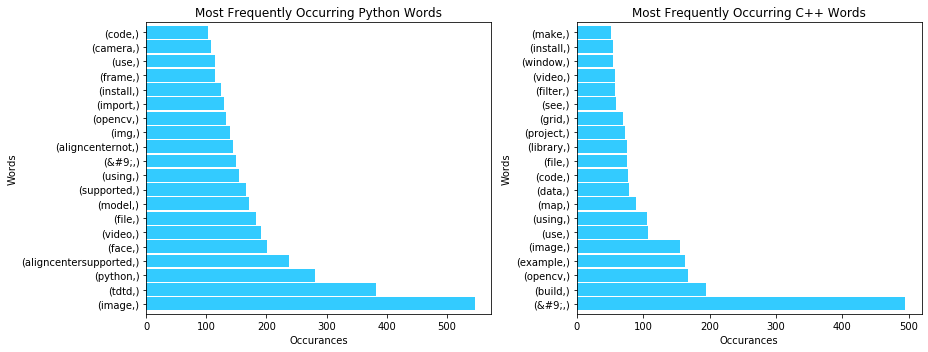

In [265]:
# Single Word Subplots (Python and C++) 
single_python_words.sort_values().plot.barh(color='deepskyblue', width=.9, align='center', figsize=(10, 6))
single_c_plus_plus_words.sort_values().plot.barh(color='deepskyblue', width=.9, figsize=(10, 6))
single_all_words.sort_values().plot.barh(color='deepskyblue', width=.9, figsize=(10, 6))

plt.subplot(121)
single_python_words.plot.barh(color='deepskyblue', width=.9, align='center', figsize=(13, 5), alpha=.8)
plt.title('Most Frequently Occurring Python Words')
plt.ylabel('Words')
plt.xlabel('Occurances')

plt.subplot(122)
single_c_plus_plus_words.plot.barh(color='deepskyblue', width=.9, figsize=(13, 5), alpha=.8)
plt.title('Most Frequently Occurring C++ Words')
plt.ylabel('Words')
plt.xlabel('Occurances')

plt.tight_layout()
plt.show()

Text(0.5, 0, 'Occurances')

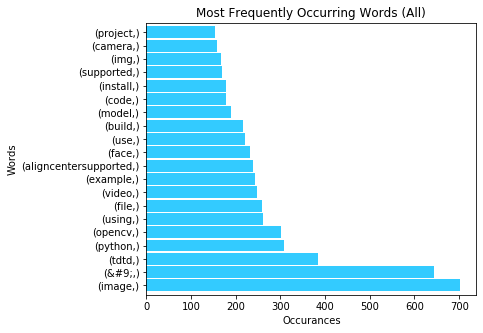

In [266]:
# Single Word Subplots (All) 
plt.subplot(121)
single_all_words.plot.barh(color='deepskyblue', width=.9, align='center', figsize=(13, 5), alpha=.8)
plt.title('Most Frequently Occurring Words (All)')
plt.ylabel('Words')
plt.xlabel('Occurances')

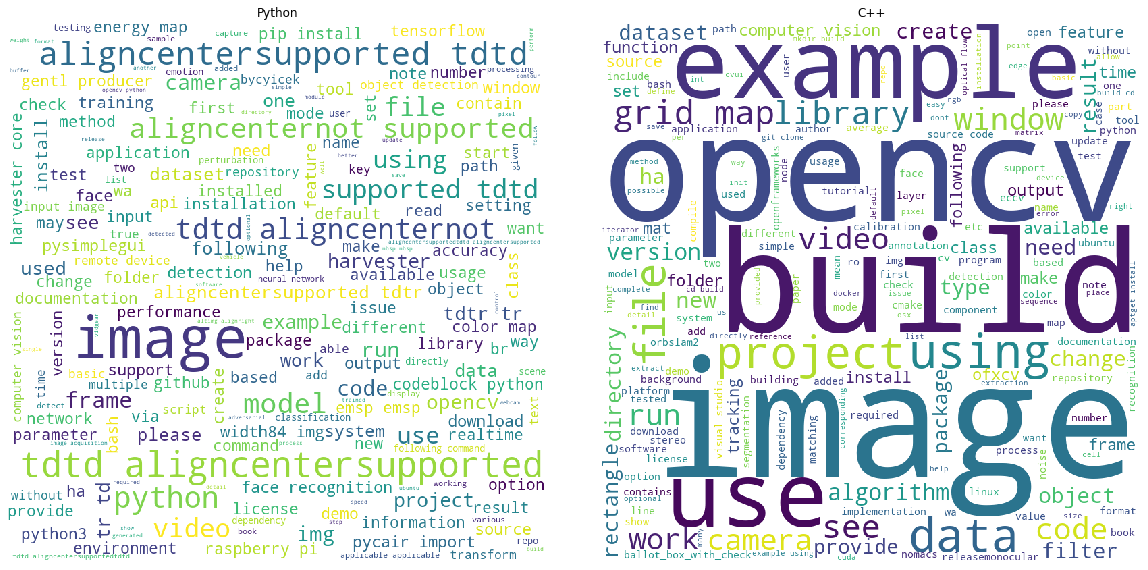

In [267]:
# Single Word, Word Clouds
python_cloud = WordCloud(background_color='white',
                      height=800, width=800).generate(python_words)

c_plus_plus_cloud = WordCloud(background_color='white', 
                      height=800, width=800).generate(c_plus_plus_words)

plt.figure(figsize=(15,15))
axs = [plt.axes([.25, 1, .5, .5]), plt.axes([.8, 1, .5, .5])]

# imshow => display data as an image
axs[0].imshow(python_cloud)
axs[1].imshow(c_plus_plus_cloud)

axs[0].set_title('Python')
axs[1].set_title('C++')

for ax in axs: ax.axis('off')

### Do different programming languages use a different number of unique words?

### Most Common Bigrams

In [268]:
# Added 'Bigram' column to dataframe
train['bigrams'] = [list(nltk.ngrams(wordlist, 2)) for wordlist in train.words]
train.head()

,language,text_filtered,words,bigrams,trigrams,doc_len
194,python,implementation paper adversarial example imple...,"[implementation, paper, adversarial, example, ...","[(implementation, paper), (paper, adversarial)...","[(implementation, paper), (paper, adversarial)...",838
201,C++,opencv code c python source code extracted tut...,"[opencv, codepython, source, code, extracted, ...","[(opencv, codepython), (codepython, source), (...","[(opencv, codepython), (codepython, source), (...",7
214,C++,superpixels evaluation stateoftheart build sta...,"[superpixels, evaluation, stateoftheart, build...","[(superpixels, evaluation), (evaluation, state...","[(superpixels, evaluation), (evaluation, state...",633
80,C++,introduction ofxcv represents alternative appr...,"[introduction, ofxcv, represents, alternative,...","[(introduction, ofxcv), (ofxcv, represents), (...","[(introduction, ofxcv), (ofxcv, represents), (...",918
190,C++,curvature filter efficient solver variational ...,"[curvature, filter, efficient, solver, variati...","[(curvature, filter), (filter, efficient), (ef...","[(curvature, filter), (filter, efficient), (ef...",544


In [269]:
# Create variables for series
python_bigrams = pd.Series(list(nltk.ngrams(python_words.split(), 2))).value_counts().head(20) 
c_plus_plus_bigrams = pd.Series(list(nltk.ngrams(c_plus_plus_words.split(), 2))).value_counts().head(20)

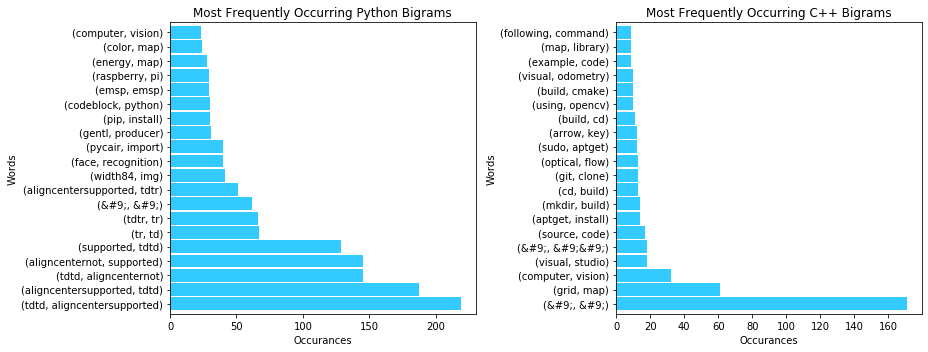

In [270]:
# Bigram Subplots 
python_bigrams.sort_values().plot.barh(color='deepskyblue', width=.9, align='center', figsize=(10, 6))
c_plus_plus_bigrams.sort_values().plot.barh(color='deepskyblue', width=.9, figsize=(10, 6))

plt.subplot(121)
python_bigrams.plot.barh(color='deepskyblue', width=.9, align='center', figsize=(13, 5), alpha=.8)
plt.title('Most Frequently Occurring Python Bigrams')
plt.ylabel('Words')
plt.xlabel('Occurances')

plt.subplot(122)
c_plus_plus_bigrams.plot.barh(color='deepskyblue', width=.9, figsize=(13, 5), alpha=.8)
plt.title('Most Frequently Occurring C++ Bigrams')
plt.ylabel('Words')
plt.xlabel('Occurances')

plt.tight_layout()
plt.show()

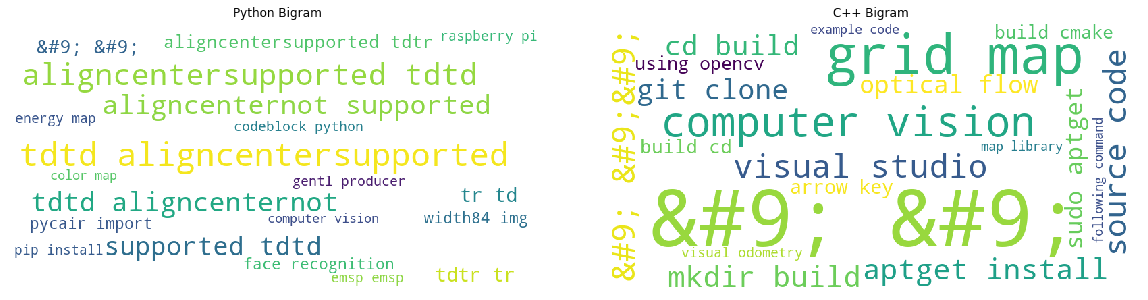

In [271]:
# Bigram Word Clouds
python_data = {k[0] + ' ' + k[1]: v for k, v in python_bigrams.to_dict().items()}
c_plus_plus_data = {k[0] + ' ' + k[1]: v for k, v in c_plus_plus_bigrams.to_dict().items()}

python_bigram_cloud = WordCloud(background_color='white', 
                width=800, height=400).generate_from_frequencies(python_data)

c_plus_plus_bigram_cloud = WordCloud(background_color='white', 
                width=800, height=400).generate_from_frequencies(c_plus_plus_data)


plt.figure(figsize=(15,15))
axs = [plt.axes([.25, 1, .5, .5]), plt.axes([.8, 1, .5, .5])]

axs[0].imshow(python_bigram_cloud)
axs[1].imshow(c_plus_plus_bigram_cloud)

axs[0].set_title('Python Bigram')
axs[1].set_title('C++ Bigram')

for ax in axs: ax.axis('off')

### Most Common Trigrams

In [272]:
# Added 'Trigram' column to dataframe
train['trigrams'] = [list(nltk.ngrams(wordlist, 3)) for wordlist in train.words]
train.head()

,language,text_filtered,words,bigrams,trigrams,doc_len
194,python,implementation paper adversarial example imple...,"[implementation, paper, adversarial, example, ...","[(implementation, paper), (paper, adversarial)...","[(implementation, paper, adversarial), (paper,...",838
201,C++,opencv code c python source code extracted tut...,"[opencv, codepython, source, code, extracted, ...","[(opencv, codepython), (codepython, source), (...","[(opencv, codepython, source), (codepython, so...",7
214,C++,superpixels evaluation stateoftheart build sta...,"[superpixels, evaluation, stateoftheart, build...","[(superpixels, evaluation), (evaluation, state...","[(superpixels, evaluation, stateoftheart), (ev...",633
80,C++,introduction ofxcv represents alternative appr...,"[introduction, ofxcv, represents, alternative,...","[(introduction, ofxcv), (ofxcv, represents), (...","[(introduction, ofxcv, represents), (ofxcv, re...",918
190,C++,curvature filter efficient solver variational ...,"[curvature, filter, efficient, solver, variati...","[(curvature, filter), (filter, efficient), (ef...","[(curvature, filter, efficient), (filter, effi...",544


In [273]:
# Create variables for series
python_trigrams = pd.Series(list(nltk.ngrams(python_words.split(), 3))).value_counts().head(20)
c_plus_plus_trigrams = pd.Series(list(nltk.ngrams(c_plus_plus_words.split(), 3))).value_counts().head(20)

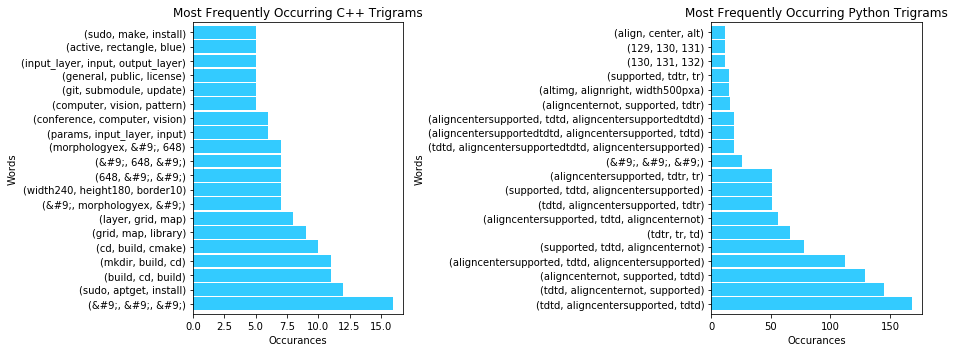

In [274]:
# Trigram Subplots 
# Switched Python and C++ graphs around to better align in this format
# Pay attention to the titles and labels
python_trigrams.sort_values().plot.barh(color='deepskyblue', width=.9, align='center', figsize=(10, 6))
c_plus_plus_trigrams.sort_values().plot.barh(color='deepskyblue', width=.9, figsize=(10, 6))

plt.subplot(121)
c_plus_plus_trigrams.plot.barh(color='deepskyblue', width=.9, figsize=(13, 5), alpha=.8)
plt.title('Most Frequently Occurring C++ Trigrams')
plt.ylabel('Words')
plt.xlabel('Occurances')

plt.subplot(122)
python_trigrams.plot.barh(color='deepskyblue', width=.9, align='center', figsize=(13, 5), alpha=.8)
plt.title('Most Frequently Occurring Python Trigrams')
plt.ylabel('Words')
plt.xlabel('Occurances')

plt.tight_layout()
plt.show()

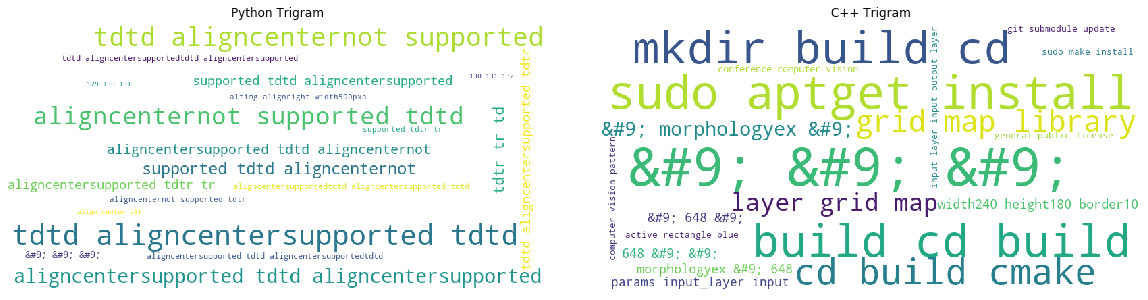

In [275]:
# Trigram Word Clouds
python_tridata = {k[0] + ' ' + k[1]+ ' ' + k[2]: v for k, v in python_trigrams.to_dict().items()}
c_plus_plus_tridata = {k[0] + ' ' + k[1]+ ' ' + k[2]: v for k, v in c_plus_plus_trigrams.to_dict().items()}

python_trigram_cloud = WordCloud(background_color='white', 
                width=800, height=400).generate_from_frequencies(python_tridata)

c_plus_plus_trigram_cloud = WordCloud(background_color='white', 
                width=800, height=400).generate_from_frequencies(c_plus_plus_tridata)


plt.figure(figsize=(15,15))
axs = [plt.axes([.25, 1, .5, .5]), plt.axes([.8, 1, .5, .5])]

axs[0].imshow(python_trigram_cloud)
axs[1].imshow(c_plus_plus_trigram_cloud)

axs[0].set_title('Python Trigram')
axs[1].set_title('C++ Trigram')

for ax in axs: ax.axis('off')

### What does the distribution of IDFs look like for the most common words?

In [276]:
# This is a function that takes in a word and generates its IDF for the whole dataframe
def idf(word):
    n_occurences = sum([1 for doc in train.text_filtered if word in doc])
    return np.log(len(df.words) / n_occurences)

In [277]:
# Now we need to make a unique word list so that there aren't any duplicate words
unique_words = pd.Series(' '.join(train.text_filtered).split()).unique()

In [278]:
# Put the unique words into a dataframe
idf_words = (pd.DataFrame(dict(word=unique_words))
# calculate the idf for each word
 .assign(idf=lambda df: df.word.apply(idf))
# set the data frames index as the word for that row
 .set_index('word')
# sort values to show max
 .sort_values(by='idf', ascending=False))
idf_words.head(10)

,idf
word,
dlls,5.192957
afterwards,5.192957
picturefooter_text2,5.192957
footer_text1,5.192957
footer_text2,5.192957
text_fonts,5.192957
amaticbold,5.192957
ttf,5.192957
robotobolditalic,5.192957


In [279]:
# Looking at some summary statistics of the idf dataframe
idf_words.describe()

,idf
count,12462.000000
mean,4.618629
std,1.035118
min,0.510826
25%,4.499810
50%,5.192957
75%,5.192957
max,5.192957


In [280]:
# Create empty dataframe to store idfs for top 5 most common python words
top_five_python = pd.DataFrame()
# for loop goes through top 5 most common python words and generates its idf before appending it to dataframe
for word in python_freq.head().index:
    hold = idf_words[idf_words.index == word]
    top_five_python = top_five_python.append(hold)

In [281]:
# sort values so that larger idf are on top and show
top_five_python.sort_values(by='idf', ascending=False)

,idf
word,
tdtd,5.192957
aligncentersupported,5.192957
face,1.280934
python,0.944462
image,0.875469


In [282]:
# Create empty dataframe to store idfs for top 5 most common C++ words
top_five_cplus2 = pd.DataFrame()
# for loop goes through top 5 most common C++ words and generates its idf before appending it to dataframe
for word in c_plus_plus_freq.head().index:
    hold = idf_words[idf_words.index == word]
    top_five_cplus2 = top_five_cplus2.append(hold)

In [283]:
# sort values so that larger idf are on top and show
top_five_cplus2.sort_values(by='idf', ascending=False)

,idf
word,
&#9;,2.101914
example,1.241713
build,1.222665
image,0.875469
opencv,0.597837


**Takeaways:**  
Python most common words has one with a huge idf but other than that remains consistent with C++

### Does the length of the README vary by programming language?

In [284]:
# First we need to make a new column that contains the length of the filtered readme
train['doc_len'] = [len(x) for x in train.words]
train.head()

,language,text_filtered,words,bigrams,trigrams,doc_len
194,python,implementation paper adversarial example imple...,"[implementation, paper, adversarial, example, ...","[(implementation, paper), (paper, adversarial)...","[(implementation, paper, adversarial), (paper,...",838
201,C++,opencv code c python source code extracted tut...,"[opencv, codepython, source, code, extracted, ...","[(opencv, codepython), (codepython, source), (...","[(opencv, codepython, source), (codepython, so...",7
214,C++,superpixels evaluation stateoftheart build sta...,"[superpixels, evaluation, stateoftheart, build...","[(superpixels, evaluation), (evaluation, state...","[(superpixels, evaluation, stateoftheart), (ev...",633
80,C++,introduction ofxcv represents alternative appr...,"[introduction, ofxcv, represents, alternative,...","[(introduction, ofxcv), (ofxcv, represents), (...","[(introduction, ofxcv, represents), (ofxcv, re...",918
190,C++,curvature filter efficient solver variational ...,"[curvature, filter, efficient, solver, variati...","[(curvature, filter), (filter, efficient), (ef...","[(curvature, filter, efficient), (filter, effi...",544


In [285]:
# Now lets look at some summary statistics
train.groupby(train.language).doc_len.describe()

,count,mean,std,min,25%,50%,75%,max
language,,,,,,,,
C++,48.0,369.979167,356.997735,7.0,141.25,270.0,520.0,1980.0
python,60.0,500.716667,740.671548,5.0,92.25,216.5,605.0,3719.0


**Takeaways:** Python on average tends to be slightly longer than C++ readmes but python also has a wider range of values with a much bigger standard deviation.

### Comparing Top Ten Words From Each Language

In [286]:
top_ten_python = word_counts['python'].sort_values(ascending=False).head(10)

top_ten_cplus2 = word_counts['C++'].sort_values(ascending=False).head(10)

top_ten_both = list(top_ten_python.index) + list(top_ten_cplus2.index)

top_ten_combined = word_counts[word_counts.index.isin(top_ten_both)]

In [287]:
top_ten_combined

,All,python,C++
&#9;,644,149,495
aligncentersupported,238,238,0
build,216,21,195
code,179,102,77
data,138,60,78
example,244,81,163
face,232,201,31
file,259,183,76
image,703,547,156
map,143,54,89


In [288]:
word_counts['pct_python'] = word_counts['python'] / word_counts['All']
word_counts['pct_cplus2'] = word_counts['C++'] / word_counts['All']

word_counts.head()

,All,python,C++,pct_python,pct_cplus2
&#9;,644,149,495,0.231366,0.768634
&#9;&#9;,19,0,19,0.000000,1.000000
&#9;b,2,0,2,0.000000,1.000000
&#9;completing,1,1,0,1.000000,0.000000
&#9;first,1,1,0,1.000000,0.000000


In [289]:
word_counts.All.sort_values()

httpwwwyoutubecomwatchfeatureplayer_embeddedvagmgyflqafm      0
httpcoscodecwangwechat_alipay_pay_picpngaligncenter           0
mcachebitmapgetheightmcachebitmapgetheight                    1
mcachebitmapgetheightmscale                                   1
mcachebitmapgetwidth                                          1
                                                           ... 
opencv                                                      301
python                                                      308
tdtd                                                        383
&#9;                                                        644
image                                                       703
Name: All, Length: 12849, dtype: int64

In [290]:
# There are words in word counts with 0 for values
word_counts = word_counts[word_counts['All'] != 0]
word_counts['All'].sort_values()

zxvf               1
loginonvskikh      1
logitech           1
longduration       1
longstanding       1
                ... 
opencv           301
python           308
tdtd             383
&#9;             644
image            703
Name: All, Length: 12847, dtype: int64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 <a list of 20 Text yticklabel objects>)

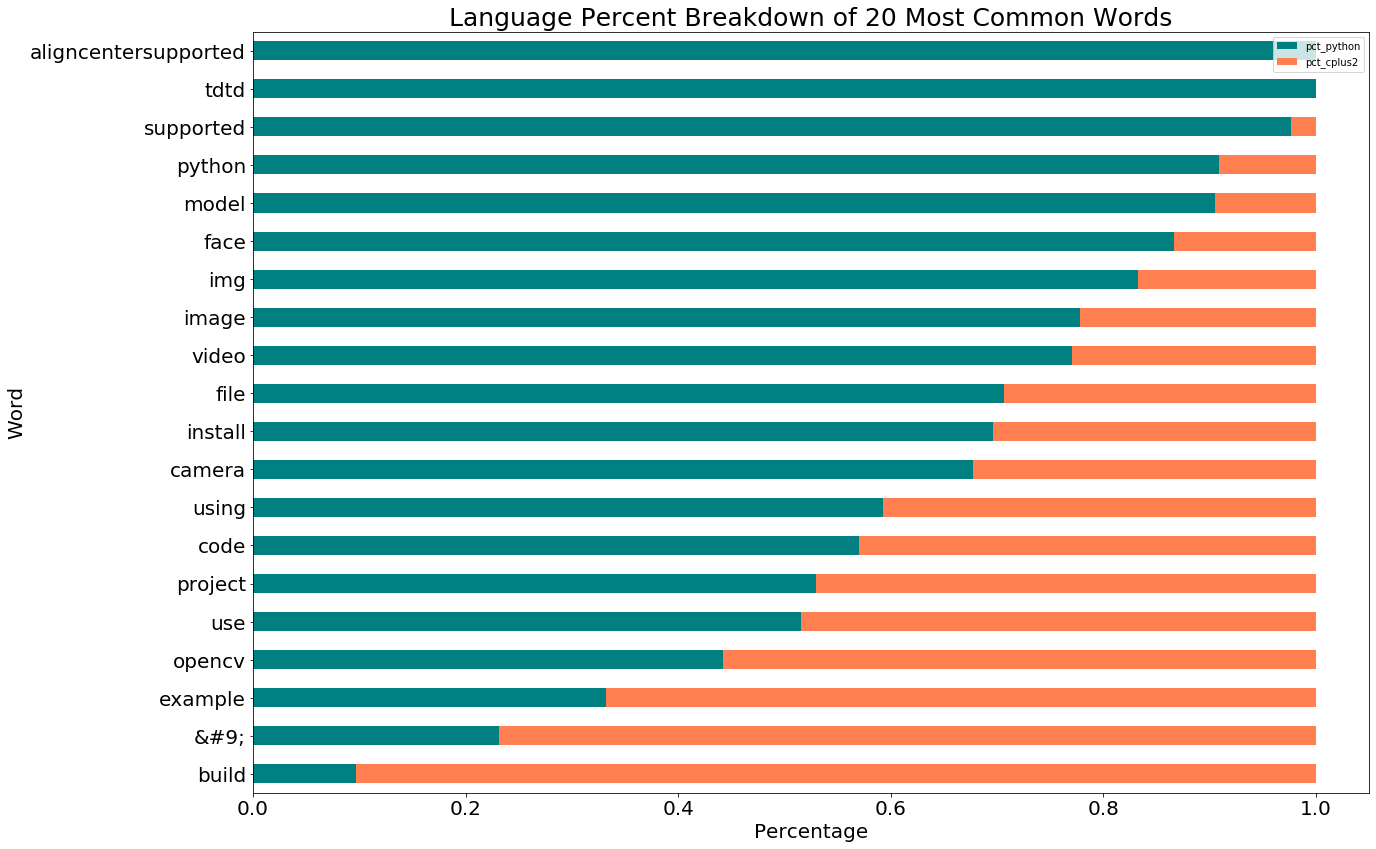

In [291]:
(word_counts.sort_values(by='All')[['pct_python', 'pct_cplus2']].tail(20).sort_values(by='pct_python')
 .plot.barh(stacked=True, figsize=(20,14), color={'teal', 'coral'}))
plt.title('Language Percent Breakdown of 20 Most Common Words', fontsize=25)
plt.xlabel('Percentage', fontsize=20)
plt.ylabel('Word', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

### Trimming Train
Now we will trim train down so that we can add features before pushing into modeling.

In [292]:
train = train.drop(columns=['bigrams', 'words', 'trigrams'])
train.head()

,language,text_filtered,doc_len
194,python,implementation paper adversarial example imple...,838
201,C++,opencv code c python source code extracted tut...,7
214,C++,superpixels evaluation stateoftheart build sta...,633
80,C++,introduction ofxcv represents alternative appr...,918
190,C++,curvature filter efficient solver variational ...,544


### Feature Engineering

In [293]:
# These four columns check for words in the text that correspond to mostly python readme texts
train['has_model'] = train.text_filtered.str.contains('model')

train['has_supported'] = (train.text_filtered.str.contains('supported') | train.text_filtered.str.contains('aligncentersupported')) 

train['has_tdtd'] = train.text_filtered.str.contains('tdtd')

train['has_python'] = train.text_filtered.str.contains('python')

# This column checks for words in the text that correspond to mostly C++ readme texts
train['has_build'] = train.text_filtered.str.contains('build')

train.head()

,language,text_filtered,doc_len,has_model,has_supported,has_tdtd,has_python,has_build
194,python,implementation paper adversarial example imple...,838,True,False,False,True,False
201,C++,opencv code c python source code extracted tut...,7,False,False,False,True,False
214,C++,superpixels evaluation stateoftheart build sta...,633,False,False,False,False,True
80,C++,introduction ofxcv represents alternative appr...,918,False,True,False,False,False
190,C++,curvature filter efficient solver variational ...,544,True,False,False,False,False


## Hypothesis Tests

### Hypothesis Test 1

$H_0$: The word model being in a document and its programming language are independent  
$H_a$: The word model being in a document and its programming language are dependent  
a = .05

In [296]:
# We will be doing a chi2 test for this hypothesis
observed = pd.crosstab(train.language, train.has_model)

chi2, p, degf, expected = stats.chi2_contingency(observed)

print(f'has_model values\nchi2: {chi2}\tp: {p}')

has_model values
chi2: 2.5905405405405384	p: 0.10750364166055652


### Hypothesis Test 2

$H_0$: The term supported or aligncentersupported being in a document and its programming language are independent  
$H_a$: The term supported or aligncentersupported being in a document is dependent on its programming language  
a = .05

In [297]:
# We will be doing a chi2 test for this hypothesis
observed = pd.crosstab(train.language, train.has_supported)

chi2, p, degf, expected = stats.chi2_contingency(observed)

print(f'has_supported values\nchi2: {chi2}\tp: {p}')

has_supported values
chi2: 0.5782591093117408	p: 0.44699550464211635


### Hypothesis Test 3

$H_0$: The term tdtd being in a document and its programming language are independent  
$H_a$: The term tdtd being in a document and its programming language are dependent  
a = .05

In [298]:
# We will be doing a chi2 test for this hypothesis
observed = pd.crosstab(train.language, train.has_tdtd)

chi2, p, degf, expected = stats.chi2_contingency(observed)

print(f'has_tdtd values\nchi2: {chi2}\tp: {p}')

has_tdtd values
chi2: 0.01261682242990656	p: 0.9105660137263277


### Hypothesis Test 4

$H_0$: The word python being in a document and its programming language are independent  
$H_a$: The word python being in a document and its programming language are dependent  
a = .05

In [301]:
# We will be doing a chi2 test for this hypothesis
observed = pd.crosstab(train.language, train.has_python)

chi2, p, degf, expected = stats.chi2_contingency(observed)

print(f'has_python values\nchi2: {chi2}\tp: {p}')

has_python values
chi2: 40.07419172932332	p: 2.444979690809216e-10


### Hypothesis Test 5

$H_0$: The word build being in a document and its programming language are independent  
$H_a$: The word build being in a document and its programming language are dependent  
a = .05

In [303]:
# We will be doing a chi2 test for this hypothesis
observed = pd.crosstab(train.language, train.has_build)

chi2, p, degf, expected = stats.chi2_contingency(observed)

print(f'has_build values\nchi2: {chi2}\tp: {p}')

has_build values
chi2: 12.004579759862775	p: 0.000530699765174549


### Hypothesis Test 6

$H_0$: The length of a documents is independent of its programming language  
$H_a$: The longer a document is the more likely it is to be a python document  
a = .05

In [306]:
# We will be performing a two-tailed t-test for this hypothesis
x1 = train[train.language == 'python'].doc_len
x2 = train[train.language == 'C++'].doc_len

stats.ttest_ind(x1, x2)

Ttest_indResult(statistic=1.1223146477484187, pvalue=0.2642644570021691)

### Hypothesis Test Takeaways:



## Modeling 

- Use the programming language of the repository as a predictive label.  


- Fit different models and using different representations of the text (e.g. simple bag of words, TF-IDF values).  


- Built a function that will take in the text of a README file and predict the programming language of repo.  

### Bag of Words

### TF-IDF

### Function

## Conclusions/Takeaways

- Even though OpenCV is primarly written in C++, most words repos are written in Python  



- Repo Languages (out of 150 total most starred repos explored):  
    - Python 42.3% ; 61 repos  
    - C++ 32.6%, 47 repos  
    - Java 4.8%, 7 repos  
    
   
- We choose to only explore Python and C++ repos because there are the most significant   



- Combined total of 108 repos explored



- Most common words for Python and C++ combined are  &#9 ; , image, and opencv  



- Curious to know the meaning behind  &#9 ; ,could not find anything over it through Google search

## Future Investigations

- Are similar patterns seen across other computer vision software repos, such as (Matlab, TensorFlow, and SimpleCV)?  


- Gather higher quantity of repo data.   


- Futher modeling could be conducted. 